# Gaze Estimation

Brief explanation of this notebook: how it came to be; motivations; link to the full explanation; and "method-alike" explanation

In [1]:
#Basic
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
from operator import add

#Aiding conversions from string to list
import ast

#Randomize
import random

#Labelling classifiers
import datetime
import joblib

#Support Vector Classification
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import tree
from joblib import dump, load
from sklearn.model_selection import GridSearchCV
from sklearn import svm
#Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pandas import DataFrame
import seaborn as sns
#PCA
import sklearn as sl
from sklearn.preprocessing import StandardScaler as ss
from sklearn.decomposition import PCA 
from sklearn import utils

## 1. Recording a video

In order to ... Just record it. Falar de algumas precauções e cuidades. IDK

## 2. Converting the video in measurable data / Data treatment

To do so, we created [datasetGenerating.py](https://github.com/antonioramiro/gaze-estimation/blob/master/datasetGenerating.py) which converts a video into an array of (~) 49 elements. yada yada yada

``demo da datasetGenerating`` .gif e o comando q se usa 

Then, to cluster every vector generated, each in an individual .txt file, we used [txtJoiner](https://github.com/antonioramiro/gaze-estimation/blob/master/txtJoiner.py), which outputs the following file yada yada. When said file is imported, the lines are read as strings, therefore it needs to be converted to a list of lists.

### 2.1 Importing the text file

In [2]:
#opening the file
with open('dataset_2020-10-04.txt') as file:
    txt_file = [line.strip() for line in file]

dataset = []
#converting a list of strings to a list of lists
counter = 0
total_lines = len(txt_file)
while counter != total_lines:
    individual_line = ast.literal_eval(txt_file[counter])
    dataset += [individual_line]
    counter+=1

meter aqui imagem do boneco, com a legenda adequada ao nosso vetor. como por aquilo bonito? fica melhor explicado por escrito do que tudo discriminado.

``[x_nose, y_nose, x_neck, y_neck, x_right ear, y_right ear, x_left ear, y_left ear, x_right eye, y_right eye, x_left eye, y_left eye, x_right hand, y_right hand, x_left hand, y_left hand, ... contextual information - 32 positions ..., quadrant]``

### 2.2 Separating data for testing and for training

Now let's get the party going. Separate data

In [3]:
testing_data = dataset[int(len(dataset)*0.8):]
training_data = dataset[:int(len(dataset)*0.8)]

 ### 2.2 Increasing sample size

inverter horizontalmente as cenas + termos o dobro dos dados. nota: a geradora do dataset cospe a resolução das imagens na sua penúltima linha

In [4]:
print('Initially, the training dataset is composed by ' + str(len(training_data)) + ' elements.')

Initially, the training dataset is composed by 5769 elements.


In [5]:
def dataDoubler(dataset):
    resolution = (640,352) 
    flipped_dataset = []

# Calculate the simetric quadrant, where the input is an int and the output is a list of 1 element.
# Given the numeration of quadrants (stated in 2.1.1), a simple addition/subtraction of 3 or 5 will yield
# the simetric quadrant

    def flipped_quadrant(quadrant):
        if quadrant in [1,3,9,11]:
            flipped_quadrant = quadrant + 3 
        elif quadrant in [4,6,12,14]:
            flipped_quadrant = quadrant - 3 
        elif quadrant in [0,2,8,10]:
            flipped_quadrant = quadrant + 5
        elif quadrant in [5,7,13,15]:
            flipped_quadrant = quadrant - 5  
        return [flipped_quadrant]

    def flip_shortlong(bigList):
        if len(bigList) != 32:
            print(bigList)
            print(len(bigList))
            return 'auch'
        else:
            newList=[bigList[5],bigList[4],bigList[7],bigList[6],bigList[1],bigList[0],bigList[3],bigList[2],\
                 bigList[13],bigList[12],bigList[15],bigList[14],bigList[9],bigList[8],bigList[11],bigList[10],\
                 bigList[16+5],bigList[16+4],bigList[16+7],bigList[16+6],bigList[16+1],bigList[16+0],bigList[16+3],bigList[16+2],\
                 bigList[16+13],bigList[16+12],bigList[16+15],bigList[16+14],bigList[16+9],bigList[16+8],bigList[16+11],bigList[16+10]]
            return newList
    
    for element in dataset:
        flipped_element = []
        for i in range(len(element) - 33):

            # Every even index (up to the 14th: indexes that correspond to coordinates of poseKeypoints) contains 
            # an X coordinate, from which can be obtained the simetric coordinate (by subtracting to the width
            # the original X), note that Y is irrelevant to horizontal simetry.

            if i%2 == 0 and element[i] != -1: 
                flipped_element += [resolution[0] - element[i]]

            else: #y or x == -1
                flipped_element += [element[i]]       

        flipped_dataset += [flipped_element + flip_shortlong(element[16:-1])  + flipped_quadrant(element[-1])]

    dataset += flipped_dataset
    return dataset

In [6]:
training_data = dataDoubler(training_data)
testing_data = dataDoubler(testing_data)

TypeError: unsupported operand type(s) for -: 'int' and 'str'

In [8]:
print('Now, it has ' + str(len(training_data)) + ' elements.')

Now, it has 11530 elements.


In [9]:
print(dataset[0])
print(len(dataset[0]))

[553.2958, 94.21242, 540.856, 132.49205, 539.92664, 80.88584, 583.92523, 95.12918, 547.5611, 80.88119, 564.77905, 87.517624, 471.04092, 187.01329, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 11]
49


In [10]:
#testar se todos têm o mesmo comprimento, ficava fixe fazer um dicionário onde os índices é a len, que está ligado ao nr de ocorrencias de essa len
a = 0
b = 0
c = []
for i in training_data:
    if len(i) == 49:
        a += 1
    elif len(i) == 51:
        b += 1
        
    else: c+= [i]

a,b,c

(11530, 0, [])

### 2.3 Feature Engineering

Dizer cenas: quais as featrures, porque poderiam ser uteis

In [11]:
def head_angle(x_nose,y_nose,x_neck,y_neck):
    #angle() calculates the angle at which the head is tilted using the coordinates of the nose and neck
    if x_nose>=0 and x_neck>=0:
        x=abs(x_nose-x_neck)
        y=abs(y_nose-y_neck)
        angle=math.atan(y/x)
        if x_nose-x_neck<0:
            angle+=math.pi/2
        return [int(angle)]
    else:
        return [-1]

    
def hand_distance(x_rhand,y_rhand,x_lhand,y_lhand,x_nose,y_nose):
    #hand_distance() calculates the distance between the hands and the face using the nose coordinates
    right=-1
    left=-1
    if x_rhand>=0 and x_nose>=0:
        right=math.sqrt((x_rhand-x_nose)**2+(y_rhand-y_nose)**2)
        
    if x_lhand>=0 and x_nose>=0:
        left=math.sqrt((x_lhand-x_nose)**2+(y_lhand-y_nose)**2)
    
    distances=[int(right),int(left)]
    return distances


def hand_angles(x_rhand,y_rhand,x_lhand,y_lhand,x_neck,y_neck):
    #hand_angles() calculates the angle between each arm and the horizontal axis
    r_angle=-1
    l_angle=-1
    if x_rhand>=0 and x_neck>=0:
        x=abs(x_rhand-x_neck)
        y=abs(y_rhand-y_neck)
        r_angle=math.atan(y/x)
    if x_lhand>=0 and x_neck>=0:
        x=abs(x_lhand-x_neck)
        y=abs(y_lhand-y_neck)
        l_angle=math.atan(y/x)
        
    angles=[int(r_angle),int(l_angle)]
    return angles

In [12]:
training_data = [i[:-1] + head_angle(i[0],i[1],i[2],i[3]) + hand_distance(i[12],i[13],i[14],i[15],i[0],i[1]) + hand_angles(i[12],i[13],i[14],i[15],i[2],i[3]) + [i[-1]] for i in training_data]
testing_data = [i[:-1] + head_angle(i[0],i[1],i[2],i[3]) + hand_distance(i[12],i[13],i[14],i[15],i[0],i[1]) + hand_angles(i[12],i[13],i[14],i[15],i[2],i[3]) + [i[-1]] for i in testing_data]

In [13]:
print(len(training_data[54]))

54


o vetor agora tem esta forma ``[x_nose, y_nose, x_neck, y_neck, x_right ear, y_right ear, x_left ear, y_left ear, x_right eye, y_right eye, x_left eye, y_left eye, x_right hand, y_right hand, x_left hand, y_left hand, ... contextual information - 32 positions ..., head angle, distance from head to hand x & y, distance from hands x & y , quadrant]``

@alex meti isto em markdown poruque acho que ja nao estava a fazer nada (?)

training_data = addFeature(training_data)
testing_data = addFeature(testing_data)

### 2.4 Balancing the dataset

Em vez de leveling, outra palavra para descrever este processo de fazer os numeros mais proximos.  Due to XXXX, some quadrants tend to be more prevalent. So in order not to confuse :p the SVM, the values should be more homogenized  Falar um pouco

Firstly lets visualise the distributtion of data with the following function

In [14]:
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import random
%matplotlib inline

def heatmap (dataset):
    #in the quadrant_count list, each number corresponds to the number of samples where the object is in that
    #quadrant so quadrant_count[0] is the number of samples in the 0 quadrant
    quadrant_count=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for i in range(len(dataset)):
        quad=dataset[i][-1]
        quadrant_count[quad]=quadrant_count[quad]+1
    data=[[quadrant_count[0],quadrant_count[1],quadrant_count[4],quadrant_count[5]],\
           [quadrant_count[2],quadrant_count[3],quadrant_count[6],quadrant_count[7]],\
           [quadrant_count[8],quadrant_count[9],quadrant_count[12],quadrant_count[13]],\
           [quadrant_count[10],quadrant_count[11],quadrant_count[14],quadrant_count[15]]]
    sns.heatmap(data, annot=True, fmt="d",linewidths=0.5,yticklabels=False,xticklabels=False,cbar=False)
    return quadrant_count

Prior to leveling, we have

[90,
 107,
 898,
 854,
 107,
 90,
 854,
 898,
 720,
 1907,
 351,
 838,
 1907,
 720,
 838,
 351]

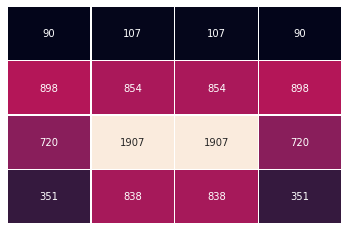

In [15]:
#dataset=[[1,1,0],[2,2,0],[1,2,1],[1,2,1],[0,0,2],[1,3,3],[3,2,3],[1,2,3],[1,5,4],[5,5,5],[1,2,6],[1,2,7],[6,2,8],[1,3,9],[2,3,9],[3,3,9],[4,3,9],[5,3,9],[3,0,10],[1,3,11],[1,2,12],[3,3,13],[4,4,14],[5,3,15],[2,3,15]]
heatmap(training_data)

In [16]:
def levelling (dataset,percent):
    #percent indicates de percentage of samples we'll allow of difference 
    #between the smallest samples and all the rest
    quadrant_count=heatmap(dataset)
    a=quadrant_count[0]
    #we'll use the following cycle to find out what is the smallest number of samples we have in one quadrant
    #(doesn't matter which quadrant that is)
    for i in quadrant_count:
        if i<a:
            a=i
    max=int((percent+1)*a)
    excess=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for i in range(len(quadrant_count)):
        if quadrant_count[i]>max:
            excess[i]=quadrant_count[i]-max
        else:
            excess[i]=0
    
    b=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    for j in dataset:
        b[j[-1]]+=[j]
    for k in range(len(b)):
        for l in range(excess[k]):
            c=random.choice(b[k])
            b[k].remove(c)
    dataset=[]
    for m in b:
        dataset+=m
    random.shuffle(dataset)
    return dataset

[90, 107, 198, 198, 107, 90, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198]

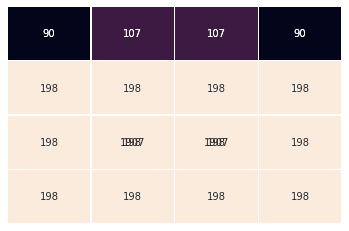

In [17]:
training_data = levelling(training_data,1.2)
heatmap(training_data)
#guardar o novo dataset em dataset, var global

[42, 42, 92, 92, 42, 42, 92, 92, 92, 92, 91, 75, 92, 92, 75, 91]

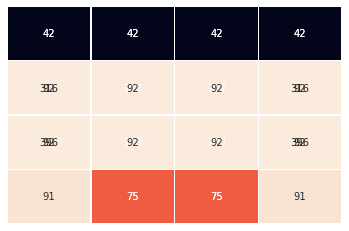

In [18]:
testing_data = levelling(testing_data,1.2)
heatmap(testing_data)

## 3. Training the models & Classifying

### 3.1 Creating a proper list of two vectors

Este step is only done here in order to reduce the probability of messing up and disconecting each X vector from the correspondant Y. X is composed of vectors with coordinates/features and Y has one, the quadrant

In [19]:
def eXifY(data):
    X, Y = [element[0:-1] for element in data], [element[-1] for element in data]
    return X, Y

In [20]:
len(eXifY(training_data)[0]) == len(eXifY(training_data)[1])

True

### 3.2 Training & Classifying

Since the goal is the comparison of the quality of the classifications according to the type of context (number of 
coordinates given), we are going to train 4 models and test them to see the differences in success rate.
Below are defined the training and testing functions, respectively.

galta adicionar mais cenas ao nome para saber do que se trata

In [21]:
def training(X,Y):
   
    nfolds=5 #5-fold cross-validation
    #Cs = [1e3,1e4,1e5,1e6,1e7,1e8,1e9] #parameter 1
    #gammas = [1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9] #parameter 2 
    #param_grid = {'C': Cs, 'gamma' : gammas} #all in one grid
    #grid_search2 = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds) #svm classifier
    #grid_search2.fit(X, Y) #fitting the data
    #best=grid_search2.best_params_ 
    
    #clf = SVC(C= best['C'],gamma=best['gamma']) #creating the model with the best parameters
    clf = SVC(C = 100,gamma = 1e-5)
    clf.fit(X, Y) #fitting the model to the data
    
    clftree = tree.DecisionTreeClassifier()
    clftree = clftree.fit(X, Y)
    #clftree.predict(X)
    #tree.plot_tree(clftree)
    #resultree = clftree.score(X, Y)
    #resultree

    now = datetime.datetime.now()
    timestamp = str(now.strftime("%d-%m-%Y_%Hh%Mm%Ss")) #the current day and time to have in the classifier name 
    

    datatype='0'
    #to insert in the name of the classifier and text files which of the 4 groups of coordinates is the classifier using
    if (len(X[0])) == 13: #(head)
        datatype='Head'
    elif (len(X[0])) == 21: #(head + hands)
        datatype='Head_Hands'
    elif (len(X[0])) == 45: #(head + context data)
        datatype='Head_Context_data_Rich'
    elif (len(X[0])) == 29: #(head + context data)
        datatype='Head_Context_data_Poor'        
    elif (len(X[0])) == 53: #(head + context data)
        datatype='All_Rich_Context'
    elif (len(X[0])) == 37: #(all) 
        datatype='All_Poor_Context'
     
    info_classif='classifier_' + timestamp + '_' + datatype +'_info.txt'
    with open(info_classif, 'w+')  as info:
        info.write('Group of Coordinates: '+ datatype + '\n')
        info.write('Type of classifier: SVM\n') # python will convert \n to os.linesep
        #info.write('C:'+str(best['C'])+'\n')
        #info.write('Gamma:'+str(best['gamma'])+'\n')

    
    classif = 'classifier_'+ timestamp + '_'+ datatype +'.joblib'
    classictree = 'experiencetree.joblib'
    dump(clf, classif) 
    dump(clftree,classictree)
                       
    return classif,info_classif,classictree

In [22]:
def testing(X,Y,classif,info_classif,classictree):
    
    clf  = joblib.load(classif)
    clftree=joblib.load(classictree)
    #clftree.predict(X)
    tree.plot_tree(clftree)
    #resultree = clftree.score(X, Y)
    #resultree
    
    result = clf.score(X, Y)
    
    Qpredicted= []
    Treepredicted= []
    i=0
    sco3=0
    sco2=0
    sco1=0
    sco0=0
    scoTREE3=0
    length=len(X)

    while i != length:
        Qpredicted+= [str(clf.predict(np.array([X[i]]))).strip('['+']'+'"')] #predict
        Y[i]= str(Y[i]) #converting to a string
        if Y[i]== Qpredicted[i]:
            sco3+=1
            
        Treepredicted+= [str(clftree.predict(np.array([X[i]]))).strip('['+']'+'"')] #predict
        Y[i]= str(Y[i]) #converting to a string
        if Y[i]== Treepredicted[i]:
            scoTREE3+=1
            
            
            
        if (Y[i]== '0' and Qpredicted[i] in ['1','2','3']) or (Y[i]== '1' and Qpredicted[i] in ['0','2','3','6','4']) or\
            (Y[i]== '2' and Qpredicted[i] in ['0','1','3','8','9']) or\
            (Y[i]== '3' and Qpredicted[i] in ['0','1','4','2','6','8','9','12']) or\
            (Y[i]== '4' and Qpredicted[i] in ['1','5','3','6','7']) or (Y[i]== '5' and Qpredicted[i] in ['4','6','7']) or\
            (Y[i]== '6' and Qpredicted[i] in ['1','4','5','3','7','9','12','13']) or\
            (Y[i]== '7' and Qpredicted[i] in ['4','5','6','12','13']) or\
            (Y[i]== '8' and Qpredicted[i] in ['2','3','9','10','11']) or\
            (Y[i]== '9' and Qpredicted[i] in ['2','3','6','8','12','10','11','14']) or\
            (Y[i]== '10' and Qpredicted[i] in ['8','9','11']) or (Y[i]== '11' and Qpredicted[i] in ['8','9','12','10','14']) or\
            (Y[i]== '12' and Qpredicted[i] in ['3','6','7','9','13','11','15']) or\
            (Y[i]== '13' and Qpredicted[i] in ['6','7','12','14','15']) or\
            (Y[i]== '14' and Qpredicted[i] in ['9','12','13','11','15']) or (Y[i]== '15' and Qpredicted[i] in ['12','13','14']):
            sco2+=1  
        if (Y[i]== '0' and Qpredicted[i] in ['4','6','8','9','12']) or\
            (Y[i]== '1' and Qpredicted[i] in ['8','9','12','13','7','5']) or\
            (Y[i]== '2' and Qpredicted[i] in ['4','6','12','14','10','11']) or\
            (Y[i]== '3' and Qpredicted[i] in ['10','11','14','15','13','7','5']) or\
            (Y[i]== '4' and Qpredicted[i] in ['0','2','8','9','12','13']) or\
            (Y[i]== '5' and Qpredicted[i] in ['1','3','9','12','13']) or\
            (Y[i]== '6' and Qpredicted[i] in ['0','2','8','10','11','14','15']) or\
            (Y[i]== '7' and Qpredicted[i] in ['1','3','9','11','14','15']) or\
            (Y[i]== '8' and Qpredicted[i] in ['0','1','4','6','12','14']) or\
            (Y[i]== '9' and Qpredicted[i] in ['0','1','4','5','7','13','15']) or\
            (Y[i]== '10' and Qpredicted[i] in ['2','3','6','12','14']) or\
            (Y[i]== '11' and Qpredicted[i] in ['2','3','6','7','13','15']) or\
            (Y[i]== '12' and Qpredicted[i] in ['10','8','2','0','1','4','5']) or\
            (Y[i]== '13' and Qpredicted[i] in ['1','4','5','3','9','11']) or\
            (Y[i]== '14' and Qpredicted[i] in ['2','3','6','7','8','10'])or\
            (Y[i]== '15' and Qpredicted[i] in ['3','6','7','9','11']):
            sco1+=1
        if (Y[i]== '0' and Qpredicted[i] in ['5','7','13','15','10','11','14']) or\
            (Y[i] in ['1','4'] and Qpredicted[i] in ['10','11','14','15']) or\
            (Y[i] in ['2','8'] and Qpredicted[i] in ['5','7','13','15']) or\
            (Y[i]== '5' and Qpredicted[i] in ['0','2','8','10','11','14','15']) or\
            (Y[i] in ['7','13'] and Qpredicted[i] in ['0','2','8','10']) or\
            (Y[i]== '10' and Qpredicted[i] in ['0','1','4','5','7','13','15']) or\
            (Y[i] in ['11','14'] and Qpredicted[i] in ['0','1','4','5']) or\
            (Y[i]== '15' and Qpredicted[i] in ['0','2','8','10','1','4','5']):
            sco0+=1 
        i+=1

            
    rangescore= (3*sco3+2*sco2+sco1)
    rangescoreper=(rangescore/(3*len(Y)))*100
    sco3per= sco3/len(Y)*100
    sco2per= sco2/len(Y)*100
    sco1per= sco1/len(Y)*100
    sco0per= sco0/len(Y)*100
    
    sco3TREEE= scoTREE3/len(Y)*100
    print('TREE SCORE =' + str(round(sco3TREEE,2))+ ' %\n') 
        
    print('The percentage of success was: ' + str(round(result*100))+ ' %\n')
    print('The range score was ' + str(rangescore) + ' out of ' + str(3*len(Y)) + ' : ' + str(round(rangescoreper,2)) + ' % \n')
    print('The score 3 was: ' + str(round(sco3per,2))+ ' %\n')
    print('The score 2 was: ' + str(round(sco2per,2))+ ' %\n')
    print('The score 1 was: ' + str(round(sco1per,2))+ ' %\n')
    print('The score 0 was: ' + str(round(sco0per,2))+ ' %\n')
    
    with open(info_classif, 'a')  as info:
        info.write('\n----\n')
        info.write('The percentage of success was: ' + str(round(result*100)) + ' %\n')
        info.write('The range score was ' + str(rangescore) + ' out of ' + str(3*len(Y)) + ' : ' + str(round(rangescoreper,2)) + ' % \n')
        info.write('The score 3 was: ' + str(round(sco3per,2))+ ' %\n')
        info.write('The score 2 was: ' + str(round(sco2per,2))+ ' %\n')
        info.write('The score 1 was: ' + str(round(sco1per,2))+ ' %\n')
        info.write('The score 0 was: ' + str(round(sco0per,2))+ ' %\n')
        
    CONF= confusion_matrix(np.array(Y), np.array(Qpredicted))
    
    labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    print(classification_report(np.array(Y), np.array(Qpredicted), labels=labels))

    return CONF, result, Qpredicted

#bengala para perceber melhor o vetor
training_data = [['xnose','ynose','xneck','yneck','xR_ear','yR_ear','xL_ear','yL_ear','xR_eye','yR_eye','xL_eye','yL_eye','xR_hand','yR_hand','xL_hand','yL_hand',8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,'headangle','r_hand-head','l_hand-head','r_headangle','l_headangle','Q']] +  training_data

training_data

#### 3.2.1 Using only the face keypoints

Since we're only using  the keypoints of the head, we'll delete context information about the difference short/long distance object and hands coordinates. <br> 
The head coordinates are the first 12 (5*2) (x,y).

Below we will:<br> 
 - Delete the coordinates we don't need (mentioned before) from the whole training data;<br> 
 - Train the model with only the head coordinates using the training function (defined before);<br> 
 - Delete the coordinates we don't need (mentioned before) from the whole testing data;<br> 
 - Test the model with only the head coordinates using the training function (defined before).

In [ ]:
print(training_data[0])

In [ ]:
X, Y = eXifY(training_data)
X = [element[:12] + [element[-5]] for element in X]
print(len(X[0]))
print(X[0])


In [ ]:
classif,info_classif=training(X,Y)

In [ ]:
X, Y = eXifY(testing_data)
X = [element[:12] + [element[-5]] for element in X]
len(X[0])

In [ ]:
CONF1, result, Qpredicted = testing(X,Y,classif,info_classif)
#print(Qpredicted)
#print(Y)
print(CONF1)

#### 3.2.2 Using only keypoints (face + hands)

Since we're only using  the keypoints of the head and the hands, we'll delete context information about the difference short/long distance object.<br> 
The keypoints (head + hands) coordinates are the first 10 (5*2) + 4 (2*2)(x,y), giving a total of 14.<br> 
The rest of the procedure is the same as in 3.2.1.:

Below we will:<br> 
 - Delete the coordinates we don't need (mentioned before) from the whole training data;<br> 
 - Train the model with only the head + hand coordinates using the training function (defined before);<br> 
 - Delete the coordinates we don't need (mentioned before) from the whole testing data;<br> 
 - Test the model with only the head + hand coordinates using the training function (defined before).

In [ ]:
X, Y = eXifY(training_data)
X = [element[:16] + element[48:] for element in X]
len(X[0])

In [ ]:
classif,info_classif=training(X,Y)

In [ ]:
X, Y = eXifY(testing_data)
X = [element[:16] + element[48:] for element in X]
len(X[0])

In [ ]:
CONF2, result, Qpredicted = testing(X,Y,classif,info_classif)
#print(Qpredicted)
#print(Y)
print(CONF2)

#### 3.2.3 Using only the keypoints of the head and context data

Since we're only using  the keypoints of the head and the context information about the difference short/long distance object, we'll delete the hand coordinates.<br> 
The keypoints of the head coordinates are the first 10 (5*2) and the context data goes from the 15 to the 46 coordinates (but on the code we have to do it from 14th to start on the 15th) giving a total of 42 coordinates.<br>
The rest of the procedure is the same as in 3.2.1.:

Below we will:<br>
 - Delete the coordinates we don't need (mentioned before) from the whole training data;<br>
 - Train the model with only the head + context data coordinates using the training function (defined before);<br>
 - Delete the coordinates we don't need (mentioned before) from the whole testing data;<br>
 - Test the model with only the head + context data coordinates using the training function (defined before).

##### rich context

In [ ]:
X, Y = eXifY(training_data)
X = [element[:12] + element[16:49] for element in X]
print(len(X[0]))
print(X[0])

In [ ]:
classif,info_classif=training(X,Y)

In [ ]:
X, Y = eXifY(testing_data)
X = [element[:12] + element[16:49] for element in X]
print(len(X[0]))
print(X[0])

In [ ]:
CONF3, result, Qpredicted = testing(X,Y,classif,info_classif)
print(Qpredicted)
#print(Y)
#print(CONF3)

##### poor context

In [ ]:
#merging short and long
X, Y = eXifY(training_data)
X = [element[:12] + list(map(add,element[16:32],element[32:48])) + [element[48]] for element in X]
len(X[0])

In [ ]:
print(X[0])

In [ ]:
classif,info_classif=training(X,Y)

In [ ]:
X, Y = eXifY(testing_data)
X = [element[:12] + list(map(add,element[16:32],element[32:48])) + [element[48]] for element in X]

In [ ]:
print(len(X[0]))

In [ ]:
CONF4, result, Qpredicted = testing(X,Y,classif,info_classif)
print(Qpredicted)
#print(Y)
#print(CONF4)

#### 3.2.4 Using all the coordinates (keypoints of the head, hands and context data)

##### rich context

In [ ]:
X, Y = eXifY(training_data)
len(X[0])

In [ ]:
len(X)

In [ ]:
len(Y)

In [ ]:
classif,info_classif=training(X,Y)

In [ ]:
X, Y = eXifY(testing_data)

In [ ]:
len(X[0])

In [ ]:
CONF5, result, Qpredicted = testing(X,Y,classif,info_classif)
#print(Qpredicted)
#print(Y)
print(CONF5)

##### poor context

In [ ]:
X, Y = eXifY(training_data)
X = [element[:16] + list(map(add,element[16:32],element[32:48])) + element[48:] for element in X]
len(X[0])

In [ ]:
len(X)

In [ ]:
len(Y)

In [ ]:
classif,info_classif=training(X,Y)

In [ ]:
X, Y = eXifY(testing_data)
X = [element[:16] + list(map(add,element[16:32],element[32:48])) + element[48:] for element in X]

In [ ]:
len(X[0])

In [ ]:
CONF6, result, Qpredicted = testing(X,Y,classif,info_classif)
#print(Qpredicted)
#print(Y)
print(CONF6)

#### 3.2.5 Using PCA coordinates

In [ ]:
X, Y_train = eXifY(training_data)

pca = PCA(0.99)
pca.fit(X) #fit do pca no treino


X_train=pca.transform(X) #transform do pca no treino

print ( "Components = " + str(pca.n_components_) + ";")
print ("Total explained variance = " + str(round(pca.explained_variance_ratio_.sum(),5)))  

X2, Y_test= eXifY(testing_data)

X_test =pca.transform(X2) 



# Set the parameters by cross-validation
tuned_parameters = [{ 'gamma': [1e-3, 1e-4, 1e-5,1e-6,1e-7,1e-8,1e-9],
                     'C': [1, 10, 100, 1000, 1e4, 1e5]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score, cv=5
    )
    clf.fit(X_train, Y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = Y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

In [23]:
X, Y = eXifY(training_data)
np.shape(X)

(2770, 53)

In [24]:
#sc=ss()
#sc.fit(X) #fit do standard scaler
#strans=sc.transform(X) #transform do standard scaler no treino

pca = PCA(0.9)
pca.fit(X) #fit do pca no treino


lol=pca.transform(X) #transform do pca no treino

#print(utils.multiclass.type_of_target(X.astype('int')))
#pca.explained_variance_ratio_
print ( "Components = " + str(pca.n_components_) + ";")
print ("Total explained variance = " + str(round(pca.explained_variance_ratio_.sum(),5)))  

Components = 5;
Total explained variance = 0.91956


#len(Y)

In [25]:
np.shape(lol)

(2770, 5)

In [26]:
classif,info_classif,classictree=training(lol,Y)

In [27]:
X2, Y2 = eXifY(testing_data)
np.shape(X2)

(1236, 53)

In [28]:
#stranstest= sc.transform(X) #transform do standard scaler no teste

lol2=pca.transform(X2) #transform do pca no teste

#print(utils.multiclass.type_of_target(X.astype('int')))
#pca.explained_variance_ratio_
#print ( "Components = " + str(pca.n_components_) + ";")
#print ("Total explained variance = " + str(round(pca.explained_variance_ratio_.sum(),5)))

In [29]:
np.shape(lol2)

(1236, 5)

TREE SCORE =100.0 %

The percentage of success was: 88.0 %

The range score was 7901 out of 8310 : 95.08 % 

The score 3 was: 88.23 %

The score 2 was: 9.17 %

The score 1 was: 2.2 %

The score 0 was: 0.14 %

              precision    recall  f1-score   support

           0       0.97      0.96      0.96        90
           1       0.90      0.95      0.93       107
           2       0.89      0.93      0.91       198
           3       0.80      0.82      0.81       198
           4       0.90      0.94      0.92       107
           5       0.95      0.93      0.94        90
           6       0.85      0.91      0.88       198
           7       0.89      0.92      0.91       198
           8       0.88      0.92      0.90       198
           9       0.83      0.78      0.80       198
          10       0.95      0.89      0.92       198
          11       0.88      0.85      0.87       198
          12       0.84      0.79      0.81       198
          13       0.87      0.89 

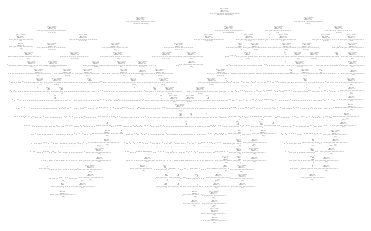

In [30]:
CONF5, result, Qpredicted = testing(lol,Y,classif,info_classif,classictree)
#print(Qpredicted)
#print(Y)
print(CONF5)

TREE SCORE =7.52 %

The percentage of success was: 10.0 %

The range score was 1814 out of 3708 : 48.92 % 

The score 3 was: 10.11 %

The score 2 was: 36.97 %

The score 1 was: 42.48 %

The score 0 was: 9.79 %

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.00      0.00      0.00        42
           2       0.18      0.10      0.13        92
           3       0.01      0.01      0.01        92
           4       0.00      0.00      0.00        42
           5       0.00      0.00      0.00        42
           6       0.00      0.00      0.00        92
           7       0.21      0.18      0.20        92
           8       0.17      0.32      0.22        92
           9       0.07      0.12      0.09        92
          10       0.05      0.02      0.03        91
          11       0.04      0.07      0.05        75
          12       0.09      0.12      0.10        92
          13       0.18      0.2

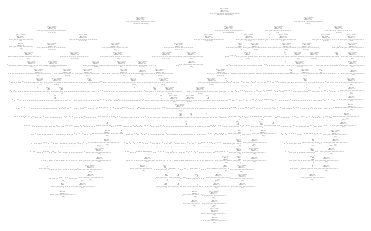

In [31]:
CONF5, result, Qpredicted = testing(lol2,Y2,classif,info_classif,classictree)
#print(Qpredicted)
#print(Y)
print(CONF5)

## 4. Comparing classifications

Now, at last, we compare the Confusion Matrices of the 4 groups of coordinates. And with a nice layout!

In [ ]:
 
plt.rcParams["figure.figsize"] = (6,6)
plt.figure()  
df = DataFrame(CONF1) #, index=Index, columns=Cols - if defined before
sns.heatmap(df, annot=True, cmap="YlGnBu",cbar=False) #cbar=True is an option but it appears float values
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix Head')
plt.show()

plt.figure() 
plt.rcParams["figure.figsize"] = (6,6)
df = DataFrame(CONF2) #, index=Index, columns=Cols - if defined before
sns.heatmap(df, annot=True, cmap="YlGnBu",cbar=False) #cbar=True is an option but it appears float values
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix Head + Hands')
plt.show()

plt.figure()
plt.rcParams["figure.figsize"] = (6,6)
df = DataFrame(CONF3) #, index=Index, columns=Cols - if defined before
sns.heatmap(df, annot=True, cmap="YlGnBu",cbar=False) #cbar=True is an option but it appears float values
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix Head + Rich Context Data')
plt.show()

plt.figure()
plt.rcParams["figure.figsize"] = (6,6)
df = DataFrame(CONF4) #, index=Index, columns=Cols - if defined before
sns.heatmap(df, annot=True, cmap="YlGnBu",cbar=False) #cbar=True is an option but it appears float values
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix Head + Poor Context Data')
#plt.subplots_adjust(wspace=0.8, hspace=0.8)
plt.show()

plt.figure()
plt.rcParams["figure.figsize"] = (6,6)
df = DataFrame(CONF5) #, index=Index, columns=Cols - if defined before
sns.heatmap(df, annot=True, cmap="YlGnBu",cbar=False) #cbar=True is an option but it appears float values
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix All (Rich Context)')
#plt.subplots_adjust(wspace=0.8, hspace=0.8)
plt.show()

plt.figure()
plt.rcParams["figure.figsize"] = (6,6)
df = DataFrame(CONF6) #, index=Index, columns=Cols - if defined before
sns.heatmap(df, annot=True, cmap="YlGnBu",cbar=False) #cbar=True is an option but it appears float values
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix All (Poor Context)')
#plt.subplots_adjust(wspace=0.8, hspace=0.8)
plt.show()

